In [7]:
import pandas as pd
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('original_data.csv')

X = data[['Tot_Benes_standard_normal_variate', 'Tot_Srvcs_standard_normal_variate', 'Avg_Mdcr_Stdzd_Amt_standard_normal_variate']]

# Standardize the features (important for DBSCAN)
X_scaled = StandardScaler().fit_transform(X)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)  # Adjust eps and min_samples based on your dataset characteristics
labels = dbscan.fit_predict(X_scaled)

# Identify points which form the core of a cluster
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

# Mark non-core points (considered as outliers in DBSCAN)
data['Far_Point'] = ~core_samples_mask

def reverse_trend(data, columns, start_index, end_index, fraction=0.01):
    """ Reverses the trend in a specific data segment for given columns."""
    poisoned_data = data.copy()
    for col in columns:
        poisoned_data.loc[start_index:end_index, col] = poisoned_data.loc[start_index:end_index, col].iloc[::-1].values
    return poisoned_data

# Columns and segment to reverse
columns_to_convert = ['Tot_Benes_standard_normal_variate', 'Tot_Srvcs_standard_normal_variate', 'Avg_Mdcr_Stdzd_Amt_standard_normal_variate']
start_index = 0
end_index = 3977

# Reverse the trend in the specified segment and columns
trend_reversed_data = reverse_trend(data, columns_to_convert, start_index, end_index)

# Output the head of the dataset and save to new CSV
print(trend_reversed_data.head())
trend_reversed_data.to_csv('trend_data_outliers_0.01_with_s_0_&_3000.csv', index=False)

   Tot_Benes  Tot_Srvcs  Avg_Mdcr_Stdzd_Amt  \
0         28       32.0              581.89   
1         29       38.0              771.93   
2         11       12.0              562.18   
3         13       22.0              117.75   
4         12       16.0              588.58   

   Tot_Benes_standard_normal_variate  Tot_Srvcs_standard_normal_variate  \
0                           0.171025                          -0.005644   
1                          -0.536889                          -0.502801   
2                          -0.451940                          -0.417084   
3                           0.907255                           0.628660   
4                          -0.565206                          -0.537088   

   Avg_Mdcr_Stdzd_Amt_standard_normal_variate  Far_Point  
0                                    1.455960      False  
1                                   -0.326763      False  
2                                   -0.155901      False  
3                             

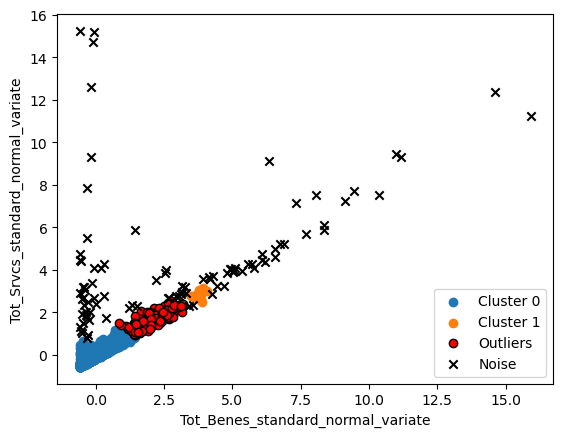

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestCentroid

# Load the data
data = pd.read_csv('trend_data_outliers_0.05_with_s_2000_&_3000.csv')

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=0.3, min_samples=10)  # eps and min_samples might need adjustment
X = data[['Tot_Benes_standard_normal_variate', 'Tot_Srvcs_standard_normal_variate']]
data['Cluster'] = dbscan.fit_predict(X)

# Determine centroids for the purpose of distance calculation
centroid_calculator = NearestCentroid()
valid_clusters = data['Cluster'] > -1
if np.any(valid_clusters):
    centroid_calculator.fit(X[valid_clusters], data.loc[valid_clusters, 'Cluster'])
    centroids = centroid_calculator.centroids_
    cluster_labels = data.loc[valid_clusters, 'Cluster']

    # Calculate distances from each point to its cluster centroid
    distances = np.sqrt(((X[valid_clusters] - centroids[cluster_labels]) ** 2).sum(axis=1))
    
    # Set a threshold to identify outliers (e.g., using 95th percentile of distances)
    threshold = np.percentile(distances, 95)
    outliers = np.zeros_like(data['Cluster'], dtype=bool)
    outliers[valid_clusters] = distances > threshold
else:
    centroids = []
    outliers = np.zeros_like(data['Cluster'], dtype=bool)

# Add 'Is_Outlier' column to the dataframe
data['Is_Outlier'] = outliers

# Plotting 2D scatter plot
plt.figure()

# Plot non-outliers
unique_clusters = set(data['Cluster']) - {-1}
for cluster_id in unique_clusters:
    cluster_data = data[(data['Cluster'] == cluster_id) & (~outliers)]
    plt.scatter(cluster_data['Tot_Benes_standard_normal_variate'], 
                cluster_data['Tot_Srvcs_standard_normal_variate'], 
                label=f'Cluster {cluster_id}')

# Plot outliers
outlier_data = data[outliers]
plt.scatter(outlier_data['Tot_Benes_standard_normal_variate'], 
            outlier_data['Tot_Srvcs_standard_normal_variate'], 
            c='red', label='Outliers', edgecolors='black')

# Plot noise points
noise_data = data[data['Cluster'] == -1]
plt.scatter(noise_data['Tot_Benes_standard_normal_variate'], 
            noise_data['Tot_Srvcs_standard_normal_variate'], 
            c='black', label='Noise', marker='x')

# Set the labels for each axis
plt.xlabel('Tot_Benes_standard_normal_variate')
plt.ylabel('Tot_Srvcs_standard_normal_variate')

# Create a legend
plt.legend()

# Show the plot
plt.show()